In [10]:
# Entities
import numpy as np
import torch

from processing.robotics.arm_propagator import ArmPropagator, ElectromagnetEndEffector
from processing.system_animation import animate_system
from processing.utilities.entities import Cylinder

# Attitude
from processing.attitude.attitude_propagator import AttitudePropagator
from processing.attitude.torques.base import TorqueObject
from processing.attitude.torques.eddy_current import EddyCurrentTorque

# Environment
from propagator.bin.environment import Environment

In [11]:
def save_step(t: float, prop: list, at: AttitudePropagator, ar: ArmPropagator):
    # Convert to numpy
    prop = np.array(prop)

    # Save arm
    if ar._timestamps is None:
        ar._timestamps = np.array([t])
        ar._prop_sol = prop[0:12].reshape(-1, 1)
    else:
        ar._timestamps = np.hstack((ar._timestamps, np.array([t])))
        ar._prop_sol = np.hstack((ar._prop_sol, prop[0:12].reshape(-1, 1)))

    # Save end effector results
    ar.end_effector._timestamps = ar._timestamps
    if ar.end_effector.locations is None:
        ar.end_effector.locations = prop[19:22].reshape(-1, 1)
        ar.end_effector.poses = prop[22:25].reshape(-1, 1)
    else:
        ar.end_effector.locations = np.hstack((ar.end_effector.locations, prop[19:22].reshape(-1, 1)))
        ar.end_effector.poses = np.hstack((ar.end_effector.poses, prop[22:25].reshape(-1, 1)))

    # Save attitude
    at._timestamps = ar._timestamps
    if at._prop_sol is None:
        at._prop_sol = prop[12:19].reshape(-1, 1)
    else:
        at._prop_sol = np.hstack((at._prop_sol, prop[12:19].reshape(-1, 1)))

    return

# System setup

In [12]:
# Generate debris
debris = Cylinder(
    mass=950.0,
    radius=2.5,
    height=5.0,
    thickness=0.1,
    sigma=35000000.0
)

# Generate robotic arms (UR10 standard)
# Joints
# TODO: Consider adjusting the scaling and the inertia matrices by considering a cylindrical simplified model
scale = 10
joints = np.array([
    [0, 0, scale*0.1807, np.pi/2],
    [0, scale*-0.6127, 0, 0],
    [0, scale*-0.57155, 0, 0],
    [0, 0, scale*0.17415, np.pi/2],
    [0, 0, scale*0.11985, -np.pi/2],
    [0, 0, scale*0.11655, 0]
])

# End effector
electromagnet: ElectromagnetEndEffector = ElectromagnetEndEffector(
    n_turns=500.0,
    radius=1.0,
    current=50.0
)
electromagnets = [electromagnet]

# External moments
# Eddy current
eddy: TorqueObject = EddyCurrentTorque(
    entity=debris,
    chaser_w0=[0.0, 0.0, 0.0],
    electromagnets=electromagnets
)

# Save attitude results
attitude = AttitudePropagator(entity=debris, M_ext=eddy)

# Save robotic arm results
base_offset = np.array([10, 0, 5])
arm = ArmPropagator(joints=joints, end_effector=electromagnet, base_offset=base_offset)

# Environment Setup

In [13]:
# Set initial conditions
y0_arm = [0.0, -0.7, -0.3, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
y0_debris = [0.1, 0.2, 0.0, 0.0, 0.0, 0.0, 1.0]

# Initialize environment
env = Environment(
    y0_arm + y0_debris,
    float(debris.inertia_matrix[0, 0]), float(debris.inertia_matrix[1, 1]), float(debris.inertia_matrix[2, 2]),
    debris.radius, debris.height, debris.thickness, debris.sigma,
    electromagnet.n_turns, electromagnet.current, electromagnet.radius,
    float(arm.base_offset[0]), float(arm.base_offset[1]), float(arm.base_offset[2]),
    scale, list(map(float, arm.joints[:, 1])), list(map(float, arm.joints[:, 2])), list(map(float, arm.joints[:, 3]))
    )

In [14]:
# Save initial conditions
t, step_ret = env.current_state()
save_step(t, step_ret, attitude, arm)

In [15]:
while t < 200:
    t, step_ret = env.step(1, [0,0,0,0,0,0])
    save_step(t, step_ret, attitude, arm)

= 1.7600e+02    y =  0.000000e+00   -7.000000e-01   -3.000000e-01    0.000000e+00    0.000000e+00    0.000000e+00    0.000000e+00
At (176) t = 1.7700e+02    y =  0.000000e+00   -7.000000e-01   -3.000000e-01    0.000000e+00    0.000000e+00    0.000000e+00    0.000000e+00
At (177) t = 1.7800e+02    y =  0.000000e+00   -7.000000e-01   -3.000000e-01    0.000000e+00    0.000000e+00    0.000000e+00    0.000000e+00
At (178) t = 1.7900e+02    y =  0.000000e+00   -7.000000e-01   -3.000000e-01    0.000000e+00    0.000000e+00    0.000000e+00    0.000000e+00
At (179) t = 1.8000e+02    y =  0.000000e+00   -7.000000e-01   -3.000000e-01    0.000000e+00    0.000000e+00    0.000000e+00    0.000000e+00
At (180) t = 1.8100e+02    y =  0.000000e+00   -7.000000e-01   -3.000000e-01    0.000000e+00    0.000000e+00    0.000000e+00    0.000000e+00
At (181) t = 1.8200e+02    y =  0.000000e+00   -7.000000e-01   -3.000000e-01    0.000000e+00    0.000000e+00    0.000000e+00    0.000000e+00
At (182) t = 1.8300e+02 

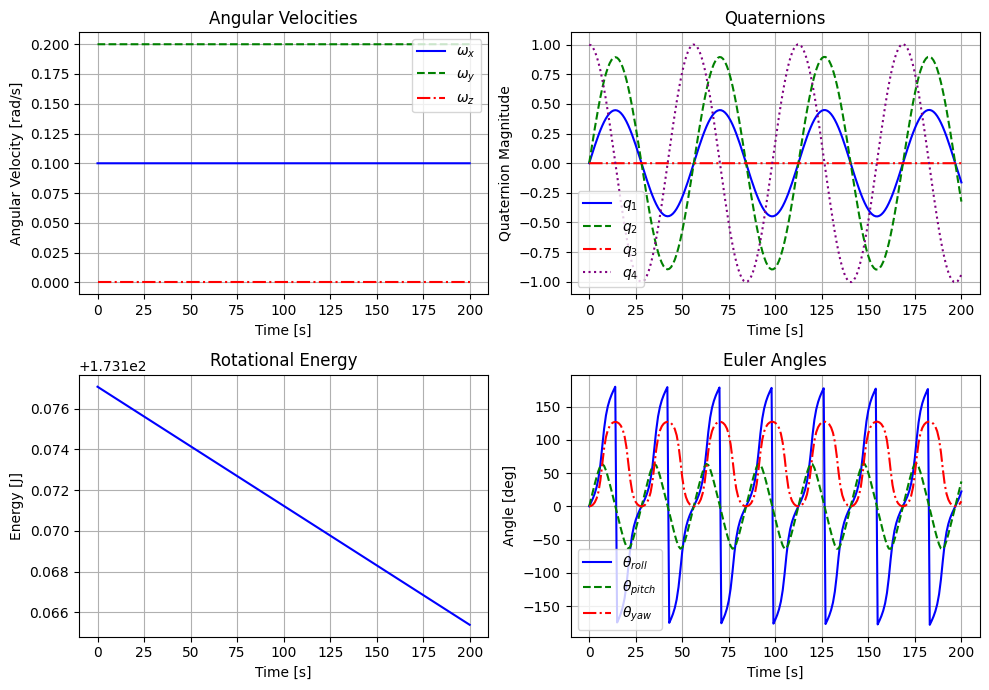

In [16]:
attitude.plot(["angular_velocity", "quaternions", "energy", "euler_angles"])

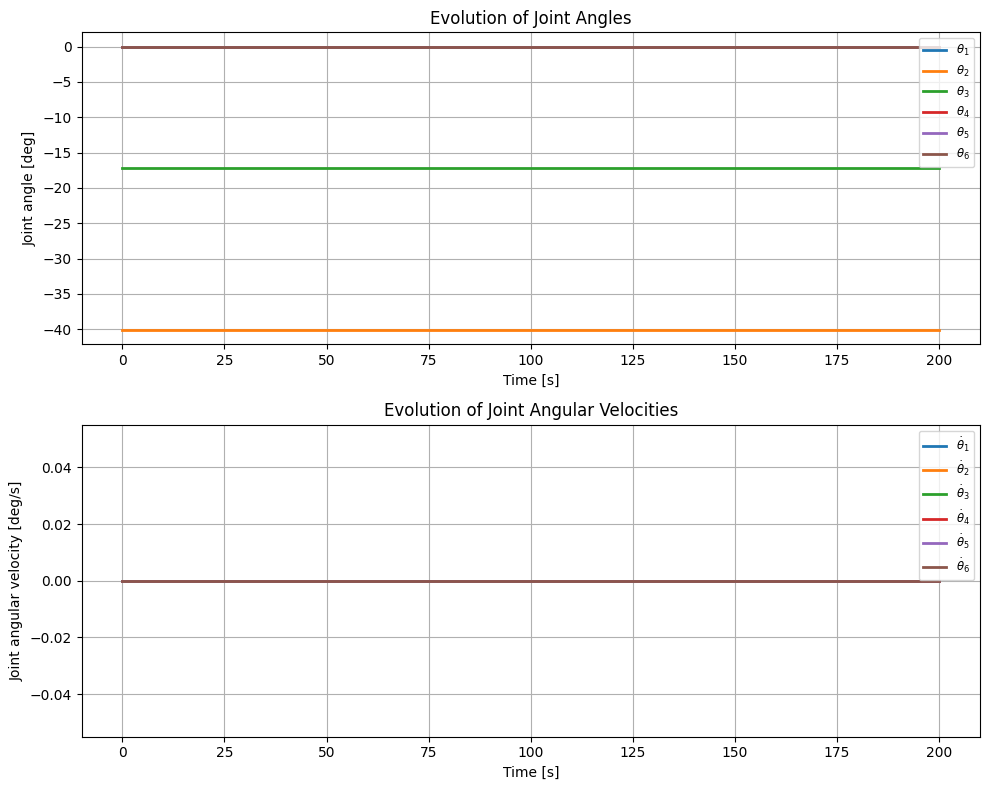

In [17]:
arm.plot()

- Animation rendering progress -
[=====================]  100.00% (201/201) ETA: 0m 0s


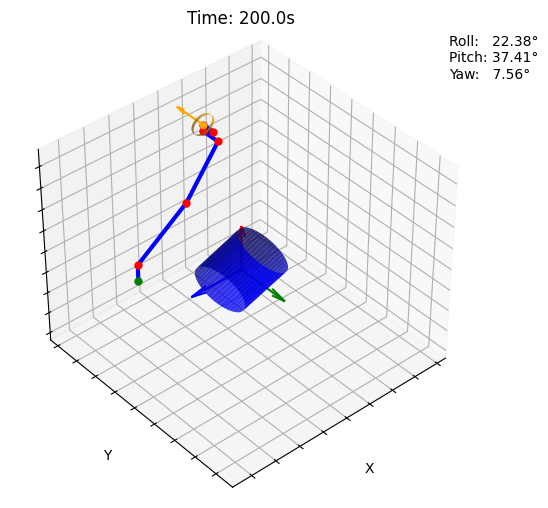

In [18]:
animate_system(
    t=attitude.t,
    q=attitude.q,
    eu=attitude.euler_angles,
    h=debris.height,
    r=debris.radius,
    dpi=300,
    arms=[arm],
    dh_par=joints
)